In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Device konfigürasyonu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyperparametre ayarları
num_epochs = 5
batch_size = 4
learning_rate = 0.001

In [4]:
# Verisetindeki goruntulerin range'i 0 ve 1 arasındaymis bunlari -1, 1 arasına alalim
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [6]:
# CIFAR10 verisetinde 60000 ader 32x32 resim bulunur. 10 sınıf vardır.
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True,transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data',train=False,
                                           download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes =  ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
def imshow(img):
    img = img/2 +0.5 # normalize edilen degeri geri getir.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

In [8]:
# Training resimlerinden bazılarını getirip bakalım.
dataiter = iter(train_loader)
images, labels = dataiter.next()

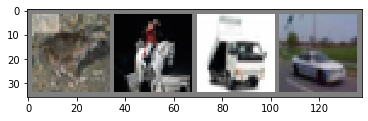

In [11]:
imshow(torchvision.utils.make_grid(images))

In [12]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x))) # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x))) # -> n, 16, 5, 5
        x = x.view(-1,16*5*5)                # -> n, 400
        x = F.relu(self.fc1(x))              # -> n, 120
        x = F.relu(self.fc2(x))              # -> n, 84
        x = self.fc3(x)                      # -> n, 10
        return x

In [13]:
model = ConvNet().to(device)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
n_total_steps = len(train_loader)

In [17]:
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        # Asil shape : [4,3,32,32] = 4,3,1024
        # Input layer = 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)
        
        #forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward ve optimizasyonlar
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if(i+1)%1000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}],Loss: {loss.item():.4f} ')

print('Egitim bitti!')
Path = './cnn.pth'
torch.save(model.state_dict(),Path)                  
    

Epoch [1/5], Step [1000/12500],Loss: 2.3041 
Epoch [1/5], Step [2000/12500],Loss: 2.3117 
Epoch [1/5], Step [3000/12500],Loss: 2.2944 
Epoch [1/5], Step [4000/12500],Loss: 2.3014 
Epoch [1/5], Step [5000/12500],Loss: 2.2997 
Epoch [1/5], Step [6000/12500],Loss: 2.2914 
Epoch [1/5], Step [7000/12500],Loss: 2.2893 
Epoch [1/5], Step [8000/12500],Loss: 2.3008 
Epoch [1/5], Step [9000/12500],Loss: 2.3039 
Epoch [1/5], Step [10000/12500],Loss: 2.2704 
Epoch [1/5], Step [11000/12500],Loss: 2.2674 
Epoch [1/5], Step [12000/12500],Loss: 2.2599 
Epoch [2/5], Step [1000/12500],Loss: 2.2474 
Epoch [2/5], Step [2000/12500],Loss: 2.1164 
Epoch [2/5], Step [3000/12500],Loss: 2.0844 
Epoch [2/5], Step [4000/12500],Loss: 1.7241 
Epoch [2/5], Step [5000/12500],Loss: 2.1825 
Epoch [2/5], Step [6000/12500],Loss: 2.2173 
Epoch [2/5], Step [7000/12500],Loss: 2.7898 
Epoch [2/5], Step [8000/12500],Loss: 1.8167 
Epoch [2/5], Step [9000/12500],Loss: 1.6953 
Epoch [2/5], Step [10000/12500],Loss: 2.1645 
Epoch 

In [22]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs,1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if(label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
        
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy for network : {acc} %')
        
    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy for network : 47.58 %
Accuracy of plane: 57.7 %
Accuracy of car: 72.0 %
Accuracy of bird: 40.6 %
Accuracy of cat: 35.9 %
Accuracy of deer: 33.0 %
Accuracy of dog: 36.7 %
Accuracy of frog: 64.6 %
Accuracy of horse: 46.1 %
Accuracy of ship: 57.8 %
Accuracy of truck: 31.4 %
